In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import butter, hilbert, filtfilt, freqz
import random
import sys
sys.path.append('/Volumes/kaylab/Code.Repository/Python/')

import OpenEphys

sf = 30000

ddir = '/Volumes/kaylab/DataStores/Data/BO/SiProbe/' # data directory

# choose data folder where files are stored
dfold = 'RK90_2016-10-31_raw_30k_30pres_Spikes_6EMB-SLim-Ger'
#clust1 = [2,3,4,5,6,7,8] # clusters 7&8 are both CH2 spikes
#clust2 = [2,3,4,5,6,7]
#clust_names = ['sh1 - multi','sh1 - multi','sh1 - multi','sh1 - CH0','sh1 - CH8',
#              'sh1 - CH2','sh1 - CH2','sh2 - multi','sh2 - multi','sh2 - CH8',
#              'sh2 - multi','sh2 - multi','sh2 - multi']


# number of odor presentations
nop = 30
# save figures?
sflag = 0;

dfold = 'RK90_2016-07-29_raw_30k_1min_S-Lim'
clust1 = [2,3] # 2 multiunit, 3 CH8 spike
clust2 = [2,3,4] # 2 multiunit, 3 CH0 spike, 4 CH10 spike

dfold = 'RK90_2016-07-29_raw_30k_1min_Acetone'

dfold = 'RK90_2016-07-29_raw_30k_1min_EMB'
clust1 = [2,3] # 2 multiunit, 3 CH8 spike
clust2 = [2,3,4] # 2 multiunit, 3 CH0 spike, 4 CH10 spike
clust_names = ['sh1 - multi','sh1 - CH8','sh2 - multi','sh2 - CH0','sh2 - CH10']       


dfold = 'RK90_2016-09-11_raw_30k_30pres_Ger'
clust1 = [2,3,4,5,6,7,8,9,10] # 9 & 10 are both ch4, should be merged
clust2 = [2,3,4,5,6]
clust_names = ['sh1 - multi','sh1 - CH12','sh1 - CH2','sh1 - CH0','sh1 - CH8',
              'sh1 - CH6','sh1 - CH14','sh1 - CH4','sh1 - CH4','sh2 - multi','sh2 - multi',
              'sh2 - CH5','sh2 - CH5','sh2 - multi']

dfold = 'RK90_2016-09-11_raw_30k_30pres_EMB'
clust1 = [2,3,4,5,6,7,8]
clust2 = [2,3,4,5,6,7,8,9]
clust_names = ['sh1 - multi','sh1 - CH0','sh1 - CH14','sh1 - multi','sh1 - CH2',
               'sh1 - multi','sh1 - multi','sh2 - multi','sh2 - multi','sh2 - CH5','sh2 - CH8',
              'sh2 - multi','sh2 - multi','sh2 - multi','sh2 - multi']

dfold = 'RK90_2016-09-14_raw_30k_30pres_PP'
clust1 = [2,3,4,5,6,7,8,9,10,11,12,13,14,15] # 7 & 5 are potentially one cluster on ch14
clust2 = [2,3,4,5,6,7,8,9] # 2 & 3 are the same multiunit cluster (periodic noise?)
clust_names = ['sh1 - CH6','sh1 - CH4','sh1 - multi','sh1 - CH14','sh1 - CH2',
              'sh1 - CH14','sh1 - multi','sh1 - multi','sh1 - CH8','sh1 - CH4','sh1 - CH12',
              'sh1 - CH10','sh1 - CH0','sh1 - multi','sh2 - multi','sh2 - multi',
              'sh2 - CH5','sh2 - CH8','sh2 - multi','sh2 - multi','sh2 - multi','sh2 - multi']

dfold = 'RK90_2016-09-29_raw_30k_30pres_EMB_awake'
clust1 = [2,3,4,5,6,7,8] # clusters 7&8 are both CH2 spikes
clust2 = [2,3,4,5,6,7]
clust_names = ['sh1 - multi','sh1 - multi','sh1 - multi','sh1 - CH0','sh1 - CH8',
              'sh1 - CH2','sh1 - CH2','sh2 - multi','sh2 - multi','sh2 - CH8',
              'sh2 - multi','sh2 - multi','sh2 - multi']
              
dfold = 'RK90_2016-09-29_raw_30k_30pres_EMB_anesth'
clust1 = [2,3,4,5,6,7,8,9]
clust2 = [2,3,4,5]
clust_names = ['sh1 - CH6','sh1 - CH14','sh1 - multi','sh1 - CH14','sh1 - CH2',
              'sh1 - CH12','sh1 - CH0','sh1 - CH8','sh2 - CH8','sh2 - multi',
              'sh2 - multi','sh2 - CH5']


dfold = 'test_2016-09-11_17-54-13__5events'

dfold = 'RK90_2016-09-11_raw_30k_30pres_EMB'

In [2]:
# load LFP data
filepath = ddir + dfold + '/' + dfold + '_LFP.dat'
ssLFP = np.fromfile(filepath, dtype='float') #subsampled LFP
sssf = 3000 # subsampled frequency
# NOTE!!! Downsampling not only saves space, but is also necessary to construct filters that 
# operate in the beta range

In [3]:
# Load events, extract odor periods
eventsname = 'all_channels.events'
filepath = ddir + dfold + '/' + eventsname
Events = OpenEphys.loadEvents(filepath)
odor_periods = Events['timestamps']-Events['timestamps'][0]
odor_periods = odor_periods[2:]
# For some odd reason the TTL pulses will sometimes duplicate a few miliseconds after eachother
# Smooth over the duplicates by binning time in 0.3s bins
dl = 10*np.squeeze(ssLFP.shape) # data length
a,b = np.histogram(odor_periods,np.arange(0,dl,0.3*sf))
b = b[1:] # The first edge is 0 so we skip it
odor_periods = b[a>0] # index where bin count is > 1
# For some reason the last TTL off is not saved, so I add one 3s after the last on
odor_periods = np.hstack((odor_periods,odor_periods[-1]+3*sf))

loading events...


In [4]:
def load_spikes_from_kwik(dfile, clust_choice):
    '''
    Inputs : dfile        - file directory (including filename)
             clust_choice - list of cluster labels you want to extract
        
    Outputs: SPK          - list of spike times for each cluster
    '''
    import h5py
    with h5py.File(dfile,'r') as D:
        # for viewing contents of folders
        # dv=D['/channel_groups/0/spikes/time_samples']
        # for i in iter(dv):
            # print(i)
        time_samples = D.get('/channel_groups/0/spikes/time_samples')
        np_time_samples = np.array(time_samples)
        cluster_labels = D.get('/channel_groups/0/spikes/clusters/main')
        np_cluster_labels = np.array(cluster_labels)
        
    SPK = []
    for i in range(len(clust_choice)):
        temp_ind = np.squeeze(np.array(np.where(np_cluster_labels == clust_choice[i])))
        SPK.append(np_time_samples[temp_ind])
    return SPK


# load spike times of each cluster for both shanks
dfile1 = ddir + dfold + '/shank1/' + dfold + '_shank1' + '.kwik'
SPK1 = load_spikes_from_kwik(dfile1, clust1)
    
dfile2 = ddir + dfold + '/shank2/' + dfold + '_shank2' + '.kwik'
SPK2 = load_spikes_from_kwik(dfile2, clust2)

SPK = SPK1+SPK2
# Spike times from both are saved in a single list SPK!

In [ ]:
# Get cluster labels
import h5py
with h5py.File(dfile1,'r') as D:
    dv=D['/channel_groups/0/clusters/original']
    for i in iter(dv):
        print(i)


In [ ]:
# Plot ISI distributions
sflag = 1

# shank1
nbins = 50
plt.figure(figsize=(28,2))
for i in range(len(clust1)):
    ISI_temp = 1000*(SPK[i][1:]-SPK[i][0:-1])/sf
    plt.subplot(1,len(clust1),i+1)
    ISI_temp = ISI_temp[ISI_temp != 0] # remove 0s (there shouldn't be any)
    plt.hist(ISI_temp, bins=np.logspace(-1,4,nbins), edgecolor = 'none')
    plt.gca().set_xscale('log')
    plt.title(clust_names[i]+'\n'+str(len(SPK[i]))+' spikes')
    plt.xlabel('ms')
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_ISI1.png', bbox_inches='tight')
        
# shank2
nbins = 50
plt.figure(figsize=(20,2))
for i in range(len(clust2)):
    ISI_temp = 1000*(SPK[i+len(clust1)][1:]-SPK[i+len(clust1)][0:-1])/sf
    plt.subplot(1,len(clust2),i+1)
    ISI_temp = ISI_temp[ISI_temp != 0] # remove 0s (there shouldn't be any)
    plt.hist(ISI_temp, bins=np.logspace(-1,4,nbins), edgecolor = 'none')
    plt.gca().set_xscale('log')
    plt.title(clust_names[i+len(clust1)]+'\n'+str(len(SPK[i+len(clust1)]))+' spikes')
    plt.xlabel('ms')
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_ISI2.png', bbox_inches='tight')    
# log(x) = 10 for x~20000 (20s)


In [ ]:
# Extract LFP in odor periods
start = odor_periods[0::2] - sf # add 1s to each end of odor period
stop = odor_periods[1::2] + sf

ssLFP_op = list()
SPK_op = list()
op_num_spk = np.zeros(len(SPK))

for i in range(nop):
    # remember, LFP is subsampled by 10
    ssLFP_op.append(ssLFP[start[i]/10:stop[i]/10])
    SPKtmp = list()
    op_num_spk_temp = np.zeros(len(SPK))
    for s in range(len(SPK)):
        # find spk times in odor periods. Don't save spikes within 10 smaples of the stop
        # to avoid later indexing issues when indexing last element of subsampled array
        sind = np.array(np.where((SPK[s] > start[i]) & (SPK[s] < (stop[i]-10))))
        sind = sind.astype(int) # convert type to int
        SPKtmp.append(SPK[s][sind]-start[i]) # subtract away start time of odor period
        op_num_spk_temp[s] = sind.size
    SPK_op.append(SPKtmp)
    op_num_spk = op_num_spk+op_num_spk_temp # total # of spikes in odor periods
    


In [ ]:
# do cells fire more or less durring odor periods?
sflag = 1

op_tot_time = np.diff(odor_periods)/sf
op_tot_time = np.sum(op_tot_time[::2]) # total time durring odor periods (s)
no_tot_time = ssLFP.size/sssf - op_tot_time # total time durring no odor periods (s)

no_num_spk = np.zeros(len(SPK))
for i in range(len(SPK)):
    no_num_spk[i] = len(SPK[i])-op_num_spk[i] # # of spikes in no odor periods


# plot results
# shank1
plt.figure(figsize=(28,2))
for i in range(len(clust1)):
    ax = plt.subplot(1,len(clust1),i+1)
    blist = plt.bar([1,2],[no_num_spk[i]/no_tot_time, op_num_spk[i]/op_tot_time])
    blist[1].set_color('r')
    plt.title(clust_names[i]+'\n')
    plt.xticks([1.3,2.3], ['No Odor', 'Odor'])
    ax.set_xticklabels(('No Odor', 'Odor'),rotation=45)
    if i == 0:
        plt.ylabel('Avg FR (Hz)')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_Tot#SPK1.png', bbox_inches='tight')
        
# shank2
nbins = 50
plt.figure(figsize=(20,2))
for i in range(len(clust2)):
    ax = plt.subplot(1,len(clust2),i+1)
    blist = plt.bar([1,2],[no_num_spk[i+len(clust1)]/
                   no_tot_time, op_num_spk[i+len(clust1)]/op_tot_time])
    blist[1].set_color('r')
    plt.title(clust_names[i+len(clust1)]+'\n')
    plt.xticks([1.3,2.3], ['No Odor', 'Odor'])
    ax.set_xticklabels(('No Odor', 'Odor'),rotation=45)
    if i == 0:
        plt.ylabel('Avg FR (Hz)')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_Tot#SPK2.png', bbox_inches='tight')


In [5]:
def butter_env(order, low, high, signal):
    b, a = butter(order, [low, high], btype='bandpass')
    filt_signal = filtfilt(b, a, signal)
    # Amplitude of analytic signal is the envelope
    hilb_filt_signal = hilbert(filt_signal)
    filt_signal_env = np.abs(hilb_filt_signal)
    # The instantaneous phase corresponds to the phase angle of the analytic signal
    filt_signal_ph = np.angle(hilb_filt_signal)
    return filt_signal, filt_signal_env, filt_signal_ph


In [ ]:
# Filter odor periods only for beta
nyq = 0.5 * sssf
low = 10 / nyq # it turns out that lowcut must be <15Hz to capture the large beta amplitude
high = 33 / nyq
order = 4

LFPb_op = list()
LFPb_env_op = list()
LFPb_ph_op = list()
for i in range(nop):
    LFPbtemp, LFPb_envtemp, LFPb_phtemp = butter_env(order, low, high, ssLFP_op[i])
    LFPb_op.append(LFPbtemp)
    LFPb_env_op.append(LFPb_envtemp)
    LFPb_ph_op.append(LFPb_phtemp)


# spike-LFP phase histograms

# These must only be calculated for regions where beta power is greater than some threshold
thb = 0.25*max(np.hstack(LFPb_env_op)) # threshold
startb_op = list()
stopb_op = list()
for i in range(nop):
    yo = LFPb_env_op[i] >= thb
    yo = yo.astype(float) # convert boolean to float
    yo = np.diff(yo)
    startb_op.append(10*np.squeeze(np.array(np.where(yo == 1)))) # multiply by 10 becaise LFP is subsampled
    stopb_op.append(10*np.squeeze(np.array(np.where(yo == -1)))) # multiply by 10 becaise LFP is subsampled

# calculate Spike-LFP phase product for thresholded regions
SPHprod = list() # SPHprod will have length = len(SPK)
for s in range(len(SPK)):
    SPHprod_temp = list()
    for i in range(nop):
        # extract spikes for each start/stop pair of the thresholded region
        for b in range(startb_op[i].size):
            if np.isscalar(startb_op[i]): # if scalar don't index by b
                bool_array =(SPK_op[i][s] > startb_op[i]) & (SPK_op[i][s] < stopb_op[i])
            else:
                bool_array =(SPK_op[i][s] > startb_op[i][b]) & (SPK_op[i][s] < stopb_op[i][b])
            sind = np.array(np.where(np.squeeze(bool_array)))
            if sind.size > 0: # trouble dealing with empty arrays
                ssinds = np.rint(0.1*np.array(SPK_op[i][s][0][sind])) # round to nearest integer
                ssinds = ssinds.astype(int) # convert type to int
                # concatenate spike-phase products
                SPHprod_temp.append(LFPb_ph_op[i][ssinds])
    # save spike-phase products for each cluster
    if len(SPHprod_temp) == 0:
        # np.hstack is unable to deal with empty entries (stupid)
        SPHprod.append(np.empty( shape=(0, 0) )) # must add empty ARRAY (not LIST) for later processing
    else:
        SPHprod.append(np.hstack(SPHprod_temp))
    
    
# Plot spike-LFP phase histograms
sflag = 1
# shank1
nbins = 15
plt.figure(figsize=(28,2))
for i in range(len(clust1)):
    plt.subplot(1,len(clust1),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprod[i].T, nbins, edgecolor = 'none')
    plt.title(clust_names[i]+'\n'+str(SPHprod[i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistB1.png', bbox_inches='tight')
        
# shank2
plt.figure(figsize=(20,2))
for i in range(len(clust2)):
    plt.subplot(1,len(clust2),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprod[i+len(clust1)].T, nbins, edgecolor = 'none')
    plt.title(clust_names[i+len(clust1)]+'\n'+str(SPHprod[i+len(clust1)].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistB2.png', bbox_inches='tight')


In [6]:
# Filter entire session for low and high gamma

# low gamma filtered LFP envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sssf
low = 35 / nyq
high = 65 / nyq
order = 5
LFPlg, LFPlg_env, LFPlg_ph = butter_env(order, low, high, ssLFP)



# high gamma filtered LFP envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sssf
low = 60 / nyq
high = 100 / nyq
order = 5
LFPhg, LFPhg_env, LFPhg_ph = butter_env(order, low, high, ssLFP)

In [ ]:
def spike_field_prod(spikes,field):
    # This function indexes field by spikes
    # NOTE: this function assumes that spikes are sampled 10x higher than field
    # spike sample times must be subsampled and rounded to index field
    ssinds = np.rint(0.1*np.array(spikes)) # round to nearest integer
    ssinds = ssinds.astype(int) # convert type to int
    SFprod = field[ssinds]
    return SFprod

In [ ]:
# obtain start and stop of low and high gamma periods above a threshold
thlg = 0.2*max(LFPlg_env) # low gamma threshold
thhg = 0.2*max(LFPhg_env) # high gamma threshold
yolg = LFPlg_env >= thlg
yohg = LFPhg_env >= thhg
yolg = yolg.astype(float) # convert boolean to float
yohg = yohg.astype(float) # convert boolean to float
yolg = np.diff(yolg)
yohg = np.diff(yohg)
startlg = np.squeeze(np.array(np.where(yolg == 1)))
stoplg = np.squeeze(np.array(np.where(yolg == -1)))
stoplg = stoplg[stoplg != 0] # if LFP happends start with high power then first stop will be 0
starthg = np.squeeze(np.array(np.where(yohg == 1)))
stophg = np.squeeze(np.array(np.where(yohg == -1)))
stophg = stophg[stophg != 0] # if LFP happends start with high power, then first stop will be 0


# Get spike-LFP phase products low/high gamma periods
SPHprodlg = list() # SPHprodlg will have length = len(SPK)
SPHprodhg = list()
lg_tot_spk = np.zeros(len(SPK)) # also save tot number of spikes in lg/hg
hg_tot_spk = np.zeros(len(SPK))
for i in range(len(SPK)):
    # low gamma
    SPHprodlg_temp = list()
    for j in range(startlg.size):
        ind_temp = np.array(np.where((SPK[i] > 10*startlg[j]) & (SPK[i] < 10*stoplg[j]-10)))
        spk_temp = SPK[i][ind_temp] - 10*startlg[j]
        SPHprodlg_temp.append(spike_field_prod(spk_temp,LFPlg_ph[startlg[j]:stoplg[j]]))
        lg_tot_spk[i] = lg_tot_spk[i] + ind_temp.size
    # save spike-phase products for each cluster
    if len(SPHprodlg_temp) == 0:
        # np.hstack is unable to deal with empty entries (stupid)
        SPHprodlg.append(np.empty( shape=(0, 0) )) 
        # must add empty ARRAY (not LIST) for later processing
    else:
        SPHprodlg.append(np.hstack(SPHprodlg_temp))
    # high gamma
    SPHprodhg_temp = list()
    for j in range(starthg.size):
        ind_temp = np.array(np.where((SPK[i] > 10*starthg[j]) & (SPK[i] < 10*stophg[j]-10)))
        spk_temp = SPK[i][ind_temp] - 10*starthg[j]
        SPHprodhg_temp.append(spike_field_prod(spk_temp,LFPhg_ph[starthg[j]:stophg[j]]))
        hg_tot_spk[i] = hg_tot_spk[i] + ind_temp.size
    # save spike-phase products for each cluster
    if len(SPHprodhg_temp) == 0:
        # np.hstack is unable to deal with empty entries (stupid)
        SPHprodhg.append(np.empty( shape=(0, 0) )) 
        # must add empty ARRAY (not LIST) for later processing
    else:
        SPHprodhg.append(np.hstack(SPHprodhg_temp))
        

# do cells fire more or less durring low/high gamma periods?
sflag = 1

# get total time in and otside of low/high gamma periods
lg_tot_time = np.sum((stoplg-startlg)/sssf)
hg_tot_time = np.sum((stophg-starthg)/sssf)
nolg_tot_time = ssLFP.size/sssf - lg_tot_time
nohg_tot_time = ssLFP.size/sssf - hg_tot_time
    
nolg_tot_spk = np.zeros(len(SPK))
nohg_tot_spk = np.zeros(len(SPK))
for i in range(len(SPK)):
    nolg_tot_spk[i] = len(SPK[i])-lg_tot_spk[i] # # of spikes in nolg periods
    nohg_tot_spk[i] = len(SPK[i])-hg_tot_spk[i] # # of spikes in nohg periods

# plot results
# shank1
plt.figure(figsize=(28,6))
for i in range(len(clust1)):
    ax = plt.subplot(2,len(clust1),i+1)
    blist = plt.bar([1,2],[nohg_tot_spk[i]/nohg_tot_time, hg_tot_spk[i]/hg_tot_time])
    blist[1].set_color('r')
    plt.title(clust_names[i]+'\n')
    plt.xticks([1.3,2.3], ['No HG', 'HG'])
    ax.set_xticklabels(('No HG', 'HG'),rotation=45)
    if i == 0:
        plt.ylabel('Avg FR (Hz)')
    ax = plt.subplot(2,len(clust1),len(clust1)+i+1)
    blist = plt.bar([1,2],[nolg_tot_spk[i]/nolg_tot_time, lg_tot_spk[i]/lg_tot_time])
    blist[1].set_color('r')
    plt.xticks([1.3,2.3], ['No LG', 'LG'])
    ax.set_xticklabels(('No LG', 'LG'),rotation=45)
    if i == 0:
        plt.ylabel('Avg FR (Hz)')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_AvgFRduringLHG1.png', bbox_inches='tight')

# shank2
plt.figure(figsize=(28,6))
for i in range(len(clust2)):
    ax = plt.subplot(2,len(clust2),i+1)
    blist = plt.bar([1,2],[nohg_tot_spk[len(clust1)+i]/nohg_tot_time, hg_tot_spk[len(clust1)+i]/hg_tot_time])
    blist[1].set_color('r')
    plt.title(clust_names[len(clust1)+i]+'\n')
    plt.xticks([1.3,2.3], ['No HG', 'HG'])
    ax.set_xticklabels(('No HG', 'HG'),rotation=45)
    if i == 0:
        plt.ylabel('Avg FR (Hz)')
    ax = plt.subplot(2,len(clust2),len(clust2)+i+1)
    blist = plt.bar([1,2],[nolg_tot_spk[len(clust1)+i]/nolg_tot_time, lg_tot_spk[len(clust1)+i]/lg_tot_time])
    blist[1].set_color('r')
    plt.xticks([1.3,2.3], ['No LG', 'LG'])
    ax.set_xticklabels(('No LG', 'LG'),rotation=45)
    if i == 0:
        plt.ylabel('Avg FR (Hz)')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_AvgFRduringLHG2.png', bbox_inches='tight')


# Plot spike-LFP phase histograms
# shank1
nbins = 15
plt.figure(figsize=(28,6))
for i in range(len(clust1)):
    plt.subplot(2,len(clust1),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodhg[i].T, nbins, edgecolor = 'none')
    plt.title(clust_names[i]+'\n'+str(SPHprodhg[i].size)+' spikes')
    plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count during HG')
    plt.subplot(2,len(clust1),len(clust1)+i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodlg[i].T, nbins, edgecolor = 'none')
    plt.title(str(SPHprodlg[i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count during LG')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistLHG1.png', bbox_inches='tight')
        
# shank2
plt.figure(figsize=(28,6))
for i in range(len(clust2)):
    plt.subplot(2,len(clust2),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodhg[len(clust1)+i].T, nbins, edgecolor = 'none')
    plt.title(clust_names[len(clust1)+i]+'\n'+str(SPHprodhg[len(clust1)+i].size)+' spikes')
    plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count during HG')
    plt.subplot(2,len(clust2),len(clust2)+i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodlg[len(clust1)+i].T, nbins, edgecolor = 'none')
    plt.title(str(SPHprodlg[len(clust1)+i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count during LG')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistLHG2.png', bbox_inches='tight')
        

In [ ]:
# Theta filtered LFP envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sssf
low = 1 / nyq
high = 13 / nyq
order = 3
LFPth, LFPth_env, LFPth_ph = butter_env(order, low, high, ssLFP)


In [ ]:
# Design Buttterworth filters and plot
nyq = 0.5 * sssf
low = 50 / nyq
high = 120 / nyq

for order in [2, 3, 4]:
    b, a = butter(order,[low, high], btype='band')
    wbw, hbw = freqz(b, a, worN=2000)
    plt.plot((sssf * 0.5 / np.pi) * wbw, abs(hbw), label="BWorder = %d" % order)
plt.xlabel('Frequency (Hz)')
plt.xlim((0,120))
plt.ylim((0,2))
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.title('Band-pass 1-13 Hz')

In [ ]:
def spike_field_prod_with_rand(spikes,field):
    # This function indexes field by spikes AND by a random array the same length as spikes
    # NOTE: this function assumes that spikes are sampled 10x higher than field
    # spike sample times must be subsampled and rounded to index ssLFP envelope
    ssinds = np.rint(0.1*np.array(spikes)) # round to nearest integer
    ssinds = ssinds.astype(int) # convert type to int
    SFprod = field[ssinds]
    # Do the same for randomly generated spikes as a control
    randinds = field.size*np.random.sample(spikes.size)
    randinds = randinds.astype(int) # convert type to int
    RFprod = field[randinds]
    return SFprod, RFprod

In [ ]:
# Spike-Theta phase histograms

SPHprodth = list() # SPHprodth will have length = len(SPK)
SPHprodth_rand = list()
for i in range(len(SPK)):
    SFprod, RFprod = spike_field_prod_with_rand(SPK[i],LFPth_ph)
    SPHprodth.append(SFprod)
    SPHprodth_rand.append(RFprod)
    
sflag = 0

# Plot spike-LFP theta phase histograms
# shank1
nbins = 15
plt.figure(figsize=(28,6))
for i in range(len(clust1)):
    plt.subplot(2,len(clust1),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth[i].T, nbins, edgecolor = 'none')
    plt.title(clust_names[i]+'\n'+str(SPHprodth[i].size)+' spikes')
    plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count')
    plt.subplot(2,len(clust1),len(clust1)+i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth_rand[i].T, nbins, edgecolor = 'none')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Rand Spk Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistTH1.png', bbox_inches='tight')
        
# shank2
plt.figure(figsize=(28,6))
for i in range(len(clust2)):
    plt.subplot(2,len(clust2),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth[len(clust1)+i].T, nbins, edgecolor = 'none')
    plt.title(clust_names[len(clust1)+i]+'\n'+str(SPHprodth[len(clust1)+i].size)+' spikes')
    plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count')
    plt.subplot(2,len(clust2),len(clust2)+i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth_rand[len(clust1)+i].T, nbins, edgecolor = 'none')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Rand Spk Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistTH2.png', bbox_inches='tight')
        


In [ ]:
# Spike-Theta analysis on first 70s only

LFPth_ph_1st70s = LFPth_ph[0:70*sssf]

SPHprodth = list() # SPHprodth will have length = len(SPK)
SPHprodth_rand = list()
SPK_1st70s = list()
for i in range(len(SPK)):
    ind_temp = np.array(np.where(SPK[i] < 10*70*sssf))
    SPK_1st70s.append(SPK[i][ind_temp])
    SFprod, RFprod = spike_field_prod_with_rand(SPK_1st70s[i],LFPth_ph_1st70s)
    SPHprodth.append(SFprod)
    SPHprodth_rand.append(RFprod)
    
sflag = 0

# Plot spike-LFP theta phase histograms
# shank1
nbins = 15
plt.figure(figsize=(28,6))
for i in range(len(clust1)):
    plt.subplot(2,len(clust1),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth[i].T, nbins, edgecolor = 'none')
    plt.title(clust_names[i]+'\n'+str(SPHprodth[i].size)+' spikes')
    plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count')
    plt.subplot(2,len(clust1),len(clust1)+i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth_rand[i].T, nbins, edgecolor = 'none')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Rand Spk Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistTH1_1st70s.png', bbox_inches='tight')
        
# shank2
plt.figure(figsize=(28,6))
for i in range(len(clust2)):
    plt.subplot(2,len(clust2),i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth[len(clust1)+i].T, nbins, edgecolor = 'none')
    plt.title(clust_names[len(clust1)+i]+'\n'+str(SPHprodth[len(clust1)+i].size)+' spikes')
    plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Spk Count')
    plt.subplot(2,len(clust2),len(clust2)+i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth_rand[len(clust1)+i].T, nbins, edgecolor = 'none')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    if i == 0:
        plt.ylabel('Rand Spk Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistTH2_1st70s.png', bbox_inches='tight')

In [ ]:
SPK_LFPb_env = []
RND_LFPb_env = []
for i in range(len(SPK)):
    SFprod, RFprod = spike_field_prod_with_rand(SPK[i],LFPb_env)
    SPK_LFPb_env.append(SFprod)
    RND_LFPb_env.append(RFprod)
    
SPK_LFPlg_env = []
RND_LFPlg_env = []
for i in range(len(SPK)):
    SFprod, RFprod = spike_field_prod_with_rand(SPK[i],LFPlg_env)
    SPK_LFPlg_env.append(SFprod)
    RND_LFPlg_env.append(RFprod)

SPK_LFPhg_env = []
RND_LFPhg_env = []
for i in range(len(SPK)):
    SFprod, RFprod = spike_field_prod_with_rand(SPK[i],LFPhg_env)
    SPK_LFPhg_env.append(SFprod)
    RND_LFPhg_env.append(RFprod)

In [ ]:
# Visualize spike field correlations
nrows = max(len(clust1),len(clust2)) # determined by max number of clusters on shank1 or2
ncol = 2

sflag = 1

# NOTE! We must use the same bin widths to compare spike-env and rand-env histograms!

nbins = 50
plt.figure(figsize=(15,15))
for i in range(len(clust1)+len(clust2)):
    plt.subplot(nrows,ncol,i+1)
    # use the same binmax to make spike-env & rand-env hist
    binmax = max(np.hstack((SPK_LFPb_env[i],RND_LFPb_env[i])))
    plt.hist(SPK_LFPb_env[i], np.linspace(0,binmax,nbins), alpha=0.5, label=clust_names[i])
    plt.hist(RND_LFPb_env[i], np.linspace(0,binmax,nbins), alpha=0.5, label='random')
    plt.legend(loc='best')
    plt.xlabel('Env. Amp.'),plt.ylabel('Count')
    plt.suptitle('Spikes with beta envelope',fontsize=18)
if sflag == 1:
    plt.savefig('figs/'+dfold+'_Bspk-env.png', bbox_inches='tight') 

nbins = 50
plt.figure(figsize=(15,15))
for i in range(len(clust1)+len(clust2)):
    plt.subplot(nrows,ncol,i+1)
    # use the same binmax to make spike-env & rand-env hist
    binmax = max(np.hstack((SPK_LFPlg_env[i],RND_LFPlg_env[i])))
    plt.hist(SPK_LFPlg_env[i], np.linspace(0,binmax,nbins), alpha=0.5, label=clust_names[i])
    plt.hist(RND_LFPlg_env[i], np.linspace(0,binmax,nbins), alpha=0.5, label='random')
    plt.legend(loc='best')
    plt.xlabel('Env. Amp.'),plt.ylabel('Count')
    plt.suptitle('Spikes with low gamma envelope',fontsize=18)
if sflag == 1:
    plt.savefig('figs/'+dfold+'_LGspk-env.png', bbox_inches='tight') 

nbins = 50
plt.figure(figsize=(15,15))
for i in range(len(clust1)+len(clust2)):
    plt.subplot(nrows,ncol,i+1)
    # use the same binmax to make spike-env & rand-env hist
    binmax = max(np.hstack((SPK_LFPhg_env[i],RND_LFPhg_env[i])))
    plt.hist(SPK_LFPhg_env[i], np.linspace(0,binmax,nbins), alpha=0.5, label=clust_names[i])
    plt.hist(RND_LFPhg_env[i], np.linspace(0,binmax,nbins), alpha=0.5, label='random')
    plt.legend(loc='best')
    plt.xlabel('Env. Amp.'),plt.ylabel('Count')
    plt.suptitle('Spikes with high gamma envelope',fontsize=18)
if sflag == 1:
    plt.savefig('figs/'+dfold+'_HGspk-env.png', bbox_inches='tight') 

In [3]:
# load raw highpass data
cont1name = '103_CH3.continuous'
cont2name = '103_CH28.continuous'
CONT1 = OpenEphys.loadContinuous(ddir + dfold + '/' + cont1name, dtype=float)
CONT1 = CONT1['data']
CONT2 = OpenEphys.loadContinuous(ddir + dfold + '/' + cont2name, dtype=float)
CONT2 = CONT2['data']

Loading continuous data...
Loading continuous data...


In [8]:
# high pass signal envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sf
#low = 200 / nyq 
#high = 1000 / nyq
low = 70 / nyq 
high = 175 / nyq
order = 3
CONT1hp, CONT1hp_env, CONT1hp_ph = butter_env(order, low, high, CONT1)

# smooth the envelope
from scipy.signal import gaussian
ga = gaussian(1000,200)
from scipy.ndimage import filters
CONT1hp_env = filters.convolve1d(CONT1hp_env, ga/ga.sum())

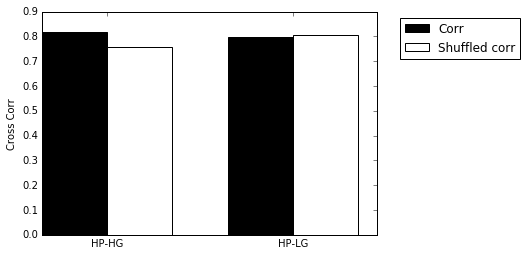

In [9]:
# correlate high pass signal env with low and high gamma env

# to run on full data use this
#ssCONT1hp_env_norm = CONT1hp_env[::10]/np.linalg.norm(CONT1hp_env[::10]) # subsample and vector normalize
#LFPhg_env_norm = LFPhg_env/np.linalg.norm(LFPhg_env) # vector normalize
#LFPlg_env_norm = LFPlg_env/np.linalg.norm(LFPlg_env) # vector normalize

# to run on first 70s only use this
ssCONT1hp_env_norm = CONT1hp_env[:sf*70:10]/np.linalg.norm(CONT1hp_env[:sf*70:10]) # subsample and vector normalize
LFPhg_env_norm = LFPhg_env[0:sssf*70]/np.linalg.norm(LFPhg_env[0:sssf*70]) # vector normalize
LFPlg_env_norm = LFPlg_env[0:sssf*70]/np.linalg.norm(LFPlg_env[0:sssf*70]) # vector normalize

#CONT1_LFPhg_corr = np.sum(np.multiply(LFPhg_env_norm,ssCONT1hp_env_norm))
CONT1_LFPhg_corr = np.correlate(LFPhg_env_norm,ssCONT1hp_env_norm)
#CONT1_LFPlg_corr = np.sum(np.multiply(LFPlg_env_norm,ssCONT1hp_env_norm))
CONT1_LFPlg_corr = np.correlate(LFPlg_env_norm,ssCONT1hp_env_norm)
# must run random.shuffle on a copy so as not to modify original
ssCONT1hp_env_norm_shuff = np.copy(ssCONT1hp_env_norm)
random.shuffle(ssCONT1hp_env_norm_shuff)
#CONT1shuff_LFPhg_corr = np.sum(np.multiply(LFPhg_env_norm,ssCONT1hp_env_norm_shuff))
CONT1shuff_LFPhg_corr = np.correlate(LFPhg_env_norm,ssCONT1hp_env_norm_shuff)
#CONT1shuff_LFPlg_corr = np.sum(np.multiply(LFPlg_env_norm,ssCONT1hp_env_norm_shuff))
CONT1shuff_LFPlg_corr = np.correlate(LFPlg_env_norm,ssCONT1hp_env_norm_shuff)

# plot results
sflag = 1
fig, ax = plt.subplots()
width = 0.35       # the width of the bars
rects1 = ax.bar(np.arange(2), (CONT1_LFPhg_corr,CONT1_LFPlg_corr), width, color='k')
rects2 = ax.bar(np.arange(2)+width, (CONT1shuff_LFPhg_corr,CONT1shuff_LFPlg_corr), width, color='w')
ax.set_ylabel('Cross Corr')
ax.set_xticks(np.arange(2) + width)
ax.set_xticklabels(('HP-HG', 'HP-LG'))
ax.legend((rects1[0], rects2[0]), ('Corr', 'Shuffled corr'),bbox_to_anchor=(1.05, 1),loc=2)
plt.show()
if sflag == 1:
    #plt.savefig('figs/'+dfold+'_HP-LFPgammCorr.png', bbox_inches='tight')
    fig.savefig('figs/'+dfold+'_HP-LFPgammCorr_1st70s.png', bbox_inches='tight')


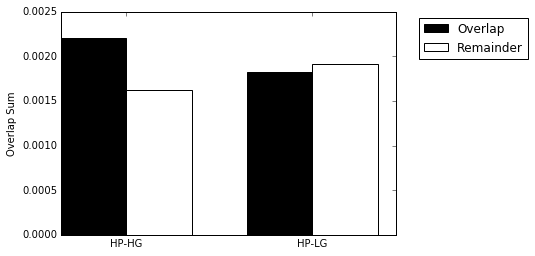

In [10]:
# obtain start and stop of high pass signal env above a threshold
# to run on full data use this
#ssCONT1hp_env_norm = CONT1hp_env[::10]/np.linalg.norm(CONT1hp_env[::10]) # subsample and vector normalize
#LFPhg_env_norm = LFPhg_env/np.linalg.norm(LFPhg_env) # vector normalize
#LFPlg_env_norm = LFPlg_env/np.linalg.norm(LFPlg_env) # vector normalize

# to run on first 70s only use this
ssCONT1hp_env_norm = CONT1hp_env[:sf*70:10]/np.linalg.norm(CONT1hp_env[:sf*70:10]) # subsample and vector normalize
LFPhg_env_norm = LFPhg_env[0:sssf*70]/np.linalg.norm(LFPhg_env[0:sssf*70]) # vector normalize
LFPlg_env_norm = LFPlg_env[0:sssf*70]/np.linalg.norm(LFPlg_env[0:sssf*70]) # vector normalize

thhp = 0.3*max(ssCONT1hp_env_norm) # highpass signal threshold
yohp = ssCONT1hp_env_norm >= thhp
yohp = yohp.astype(float) # convert boolean to float
yohp = np.diff(yohp)
starthp = np.squeeze(np.array(np.where(yohp == 1)))
stophp = np.squeeze(np.array(np.where(yohp == -1)))
# if LFP happens to start with high power then first stop might be before first start!
if stophp[0] < starthp[0]:
    stophp = stophp[1::];
# if LFP happens to end with high power then last start will not have a stop so make sure start is only
# as long as stop
starthp = starthp[0:stophp.size]

CONT1_LFPhg_overlap = 0
CONT1_LFPlg_overlap = 0
for i in range(starthp.size):
    CONT1_LFPhg_overlap = CONT1_LFPhg_overlap + np.sum(LFPhg_env_norm[starthp[i]:stophp[i]])
    CONT1_LFPlg_overlap = CONT1_LFPlg_overlap + np.sum(LFPlg_env_norm[starthp[i]:stophp[i]])

CONT1_LFPhg_nonoverlap = np.sum(LFPhg_env_norm) - CONT1_LFPhg_overlap
CONT1_LFPlg_nonoverlap = np.sum(LFPlg_env_norm) - CONT1_LFPlg_overlap
    
hp_tot_samp = np.sum((stophp-starthp))
nohp_tot_samp = LFPhg_env_norm.size - hp_tot_samp

# plot results
sflag = 1
fig, ax = plt.subplots()
width = 0.35       # the width of the bars
rects1 = ax.bar(np.arange(2), 
                (CONT1_LFPhg_overlap/hp_tot_samp,CONT1_LFPlg_overlap/hp_tot_samp), width, color='k')
rects2 = ax.bar(np.arange(2)+width, 
                (CONT1_LFPhg_nonoverlap/nohp_tot_samp,CONT1_LFPlg_nonoverlap/nohp_tot_samp), width, color='w')
ax.set_ylabel('Overlap Sum')
ax.set_xticks(np.arange(2) + width)
ax.set_xticklabels(('HP-HG', 'HP-LG'))
ax.legend((rects1[0], rects2[0]), ('Overlap', 'Remainder'),bbox_to_anchor=(1.05, 1),loc=2)
plt.show()
if sflag == 1:
    #plt.savefig('figs/'+dfold+'_OverlapSum.png', bbox_inches='tight')
    fig.savefig('figs/'+dfold+'_OverlapSum_1st70s.png', bbox_inches='tight')


In [ ]:
# Plot odor periods, LFP, and spikes for entire session
includeHP = 1
sflag = 1
sstime = np.linspace(0,ssLFP.size/sssf,ssLFP.size) # subsampled time

x1 = 0
x2 = 20
plt.figure(figsize=(16,10))
plt.eventplot(odor_periods/sf, orientation='horizontal', lineoffsets=300, linelengths=200, 
              linewidths=2, colors='k', linestyles='solid', hold=None, data=None)
plt.text(x2+0.01*(x2-x1),300,'odor periods')
plt.plot(sstime,0.1*ssLFP,color = 'b')
plt.text(x2+0.01*(x2-x1),0,'LFP',color = 'b')
if includeHP == 1:
    plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),0.3*CONT1-250,color = 'k')
    plt.text(x2+0.01*(x2-x1),-250,'sh1 - highpass',color = 'k')
    plt.plot(np.linspace(0,CONT2.size/sf,CONT2.size),0.3*CONT2-350,color = 'k')
    plt.text(x2+0.01*(x2-x1),-350,'sh2 - highpass',color = 'k')
for i in range(len(SPK)-1):
    plt.eventplot(SPK[i]/sf, orientation='horizontal', lineoffsets=-500-i*50, linelengths=40, 
              linewidths=1, colors='k', linestyles='solid', hold=None, data=None,label = 'TTL')
    plt.text(x2+0.01*(x2-x1),-500-i*50,clust_names[i])
plt.xlim([x1,x2]),plt.xlabel('Time (s)')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_OP-LFP-HP-SPK_1st20s.png', bbox_inches='tight')
    # plt.savefig('figs/'+dfold+'_beta-epochs3.png', bbox_inches='tight')
    # plt.savefig('figs/'+dfold+'_PeriodicBurst2_zoom.png', bbox_inches='tight')
    # plt.savefig('figs/'+dfold+'_GammaLeak?.png', bbox_inches='tight')


In [ ]:
# shank1
x1 = 102.45
x2 = 102.55
plt.figure(figsize=(15,10))
plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),CONT1,color = 'k')
plt.text(x2+0.01*(x2-x1),0,'sh1 - highpass',color = 'k')
for i in range(len(clust1)):
    plt.eventplot(SPK[i]/sf, orientation='horizontal', lineoffsets=-100-i*50, linelengths=40, 
              linewidths=1, colors='k', linestyles='solid', hold=None, data=None,label = 'TTL')
    plt.text(x2+0.01*(x2-x1),-100-i*50,clust_names[i])
plt.xlim([x1,x2]),plt.xlabel('Time (s)')
plt.savefig('figs/'+dfold+'_truepositives?.png', bbox_inches='tight')

# shank2
x1 = 204.45
x2 = 204.6
plt.figure(figsize=(15,10))
plt.plot(np.linspace(0,CONT2.size/sf,CONT2.size),CONT2,color = 'k')
plt.text(x2+0.01*(x2-x1),0,'sh2 - highpass',color = 'k')
for i in range(len(clust2)):
    plt.eventplot(SPK[i+len(clust1)]/sf, orientation='horizontal', lineoffsets=-100-i*50, linelengths=40, 
              linewidths=1, colors='k', linestyles='solid', hold=None, data=None,label = 'TTL')
    plt.text(x2+0.01*(x2-x1),-100-i*50,clust_names[i+len(clust1)])
plt.xlim([x1,x2]),plt.xlabel('Time (s)')
plt.savefig('figs/'+dfold+'_falsepositives?.png', bbox_inches='tight')

In [ ]:
thhp = 0.3*max(CONT1hp_env)
sstime = np.linspace(0,ssLFP.size/sssf,ssLFP.size) # subsampled time
plt.figure(figsize=(16,10))

plt.plot(sstime,0.1*ssLFP+150,color = 'b')
plt.plot(sstime,0.1*LFPhg+230,color = [0,0,0.7])
plt.text(x2+0.01*(x2-x1),+230,'high gamma',color = 'k')
plt.plot(sstime,0.1*LFPlg+280,color = [0,0,0.7])
plt.text(x2+0.01*(x2-x1),+280,'low gamma',color = 'k')
plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),CONT1,color = 'k')
plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),1.5*CONT1hp_env,color = 'r')
plt.plot(sstime,1.5*thhp*np.ones_like(sstime),color = 'y')
plt.eventplot(starthp/sssf, orientation='horizontal', lineoffsets=-100, linelengths=100, 
              linewidths=1, colors='b', linestyles='solid', hold=None, data=None,label = 'TTL')
plt.eventplot(stophp/sssf, orientation='horizontal', lineoffsets=-150, linelengths=100, 
              linewidths=1, colors='g', linestyles='solid', hold=None, data=None,label = 'TTL')
plt.xlim([0,2]),plt.xlabel('Time (s)')

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),CONT1,color = 'b')
plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),CONT1hp_env,color = 'r')
plt.plot(np.linspace(0,ssCONT1hp_env_norm.size/sssf,ssCONT1hp_env_norm.size),400+10000*ssCONT1hp_env_norm,color='g')
plt.xlim([290.65,291.0]),plt.xlabel('Time (s)')
plt.eventplot(SPK[15]/sf, orientation='horizontal', lineoffsets=-500, linelengths=400, 
              linewidths=1, colors='k', linestyles='solid', hold=None, data=None,label = 'TTL')

In [ ]:
nsamp = 60000
frq = sf*np.arange(nsamp)/nsamp
frq = frq[0:nsamp/2]
sp = np.fft.fft(CONT1[0:nsamp])
sp = abs(sp[0:nsamp/2])
plt.plot(frq, sp)
plt.xlim([0,200]),plt.xlabel('Freq (Hz)'),plt.ylabel('Power')

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(sstime,0.1*ssLFP+150,color = 'b')
plt.plot(sstime,LFPhg+150,color = 'm')
plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),1.5*CONT1hp_env,color = 'r')
plt.plot(sstime,LFPhg_env,'g')
plt.plot(sstime,LFPlg_env,'k')
plt.xlim([2,3])
plt.ylim([-50,250])

In [ ]:
ind = np.where((SPK[15]>8718000) & (SPK[15]<8736000))
spks = SPK[15][ind]
spks.size/(291.2-290.6)

In [ ]:
ddir = '/Volumes/kaylab/DataStores/Data/BO/SiProbe/' # data directory
dfold = 'RK90_2016-09-14_raw_30k_30pres_PP'
dfile = ddir + dfold + '/shank1pos/' + dfold + '_shank1' + '.kwik'

# Get cluster labels
import numpy as np
import h5py
with h5py.File(dfile,'r') as D:
    dv=D['/channel_groups/0/spikes/time_samples']
    for i in iter(dv):
        print(i)
    time_samples = D.get('/channel_groups/0/spikes/time_samples')
    np_time_samples = np.array(time_samples)

In [ ]:
from scipy.signal import gaussian
ga = gaussian(1000,200)
plt.plot(ga)

((325.95, 326), <matplotlib.text.Text at 0x1bcf9d668>)

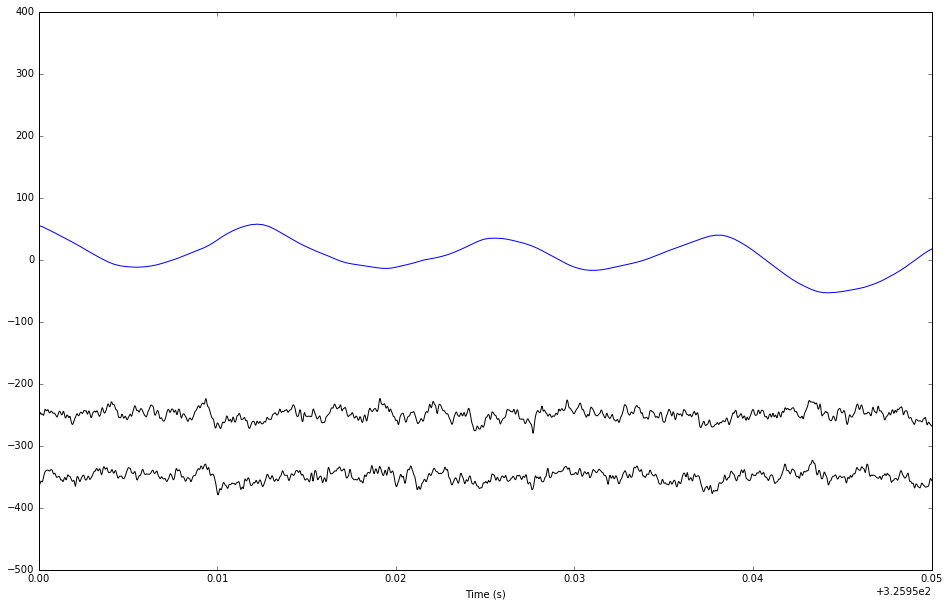

In [17]:
# quick plot of LFP and highpass

sstime = np.linspace(0,ssLFP.size/sssf,ssLFP.size) # subsampled time

x1 = 325.95
x2 = 326
plt.figure(figsize=(16,10))
plt.plot(sstime,0.1*ssLFP,color = 'b')
plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),0.3*CONT1-250,color = 'k')
plt.plot(np.linspace(0,CONT2.size/sf,CONT2.size),0.3*CONT2-350,color = 'k')
plt.xlim([x1,x2]),plt.xlabel('Time (s)')

In [ ]:
stophp[0:4]

In [ ]:
whos